# Objectives

1. Plot the distribution of:  
  a. Confidence values (UFboot and sCF).  
  b. Branches with confidence color.

---
# Setup

## Import modules

In [1]:
import os
from Bio import Phylo
import matplotlib.pyplot as plt
from matplotlib import gridspec, lines
import seaborn as sns
import math
import pandas as pd

### Input file paths

In [2]:
tree_path = "../../docs/results/latest/parse_tree/parse_tree.xml"
tree_df_path = "../../docs/results/latest/parse_tree/parse_tree.tsv"
outdir = "../../docs/results/latest/branch_support/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### General Configuration

In [3]:
from config import *

SCRIPT_NAME = "branch_support"

### Read input tree

In [4]:
tree = Phylo.read(tree_path, "phyloxml")
tree.ladderize(reverse=False)

tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


---
# 1a and 1.b Plot

### Color branches according to branch support

In [5]:
for c in tree.find_clades():
    c.color = tree_df["Branch_Support_Color"][c.name]

### Optional: Color branches according to UFboot only

In [6]:
"""for c in tree.find_clades():
    c.color = LOW_COL
    if c.is_terminal():
        c.color = TERM_COL
    for conf in c.confidences:
        if conf.type == "ufboot":
            if conf.value and conf.value >= UFBOOT_THRESH:
                c.color = HIGH_COL"""

'for c in tree.find_clades():\n    c.color = LOW_COL\n    if c.is_terminal():\n        c.color = TERM_COL\n    for conf in c.confidences:\n        if conf.type == "ufboot":\n            if conf.value and conf.value >= UFBOOT_THRESH:\n                c.color = HIGH_COL'

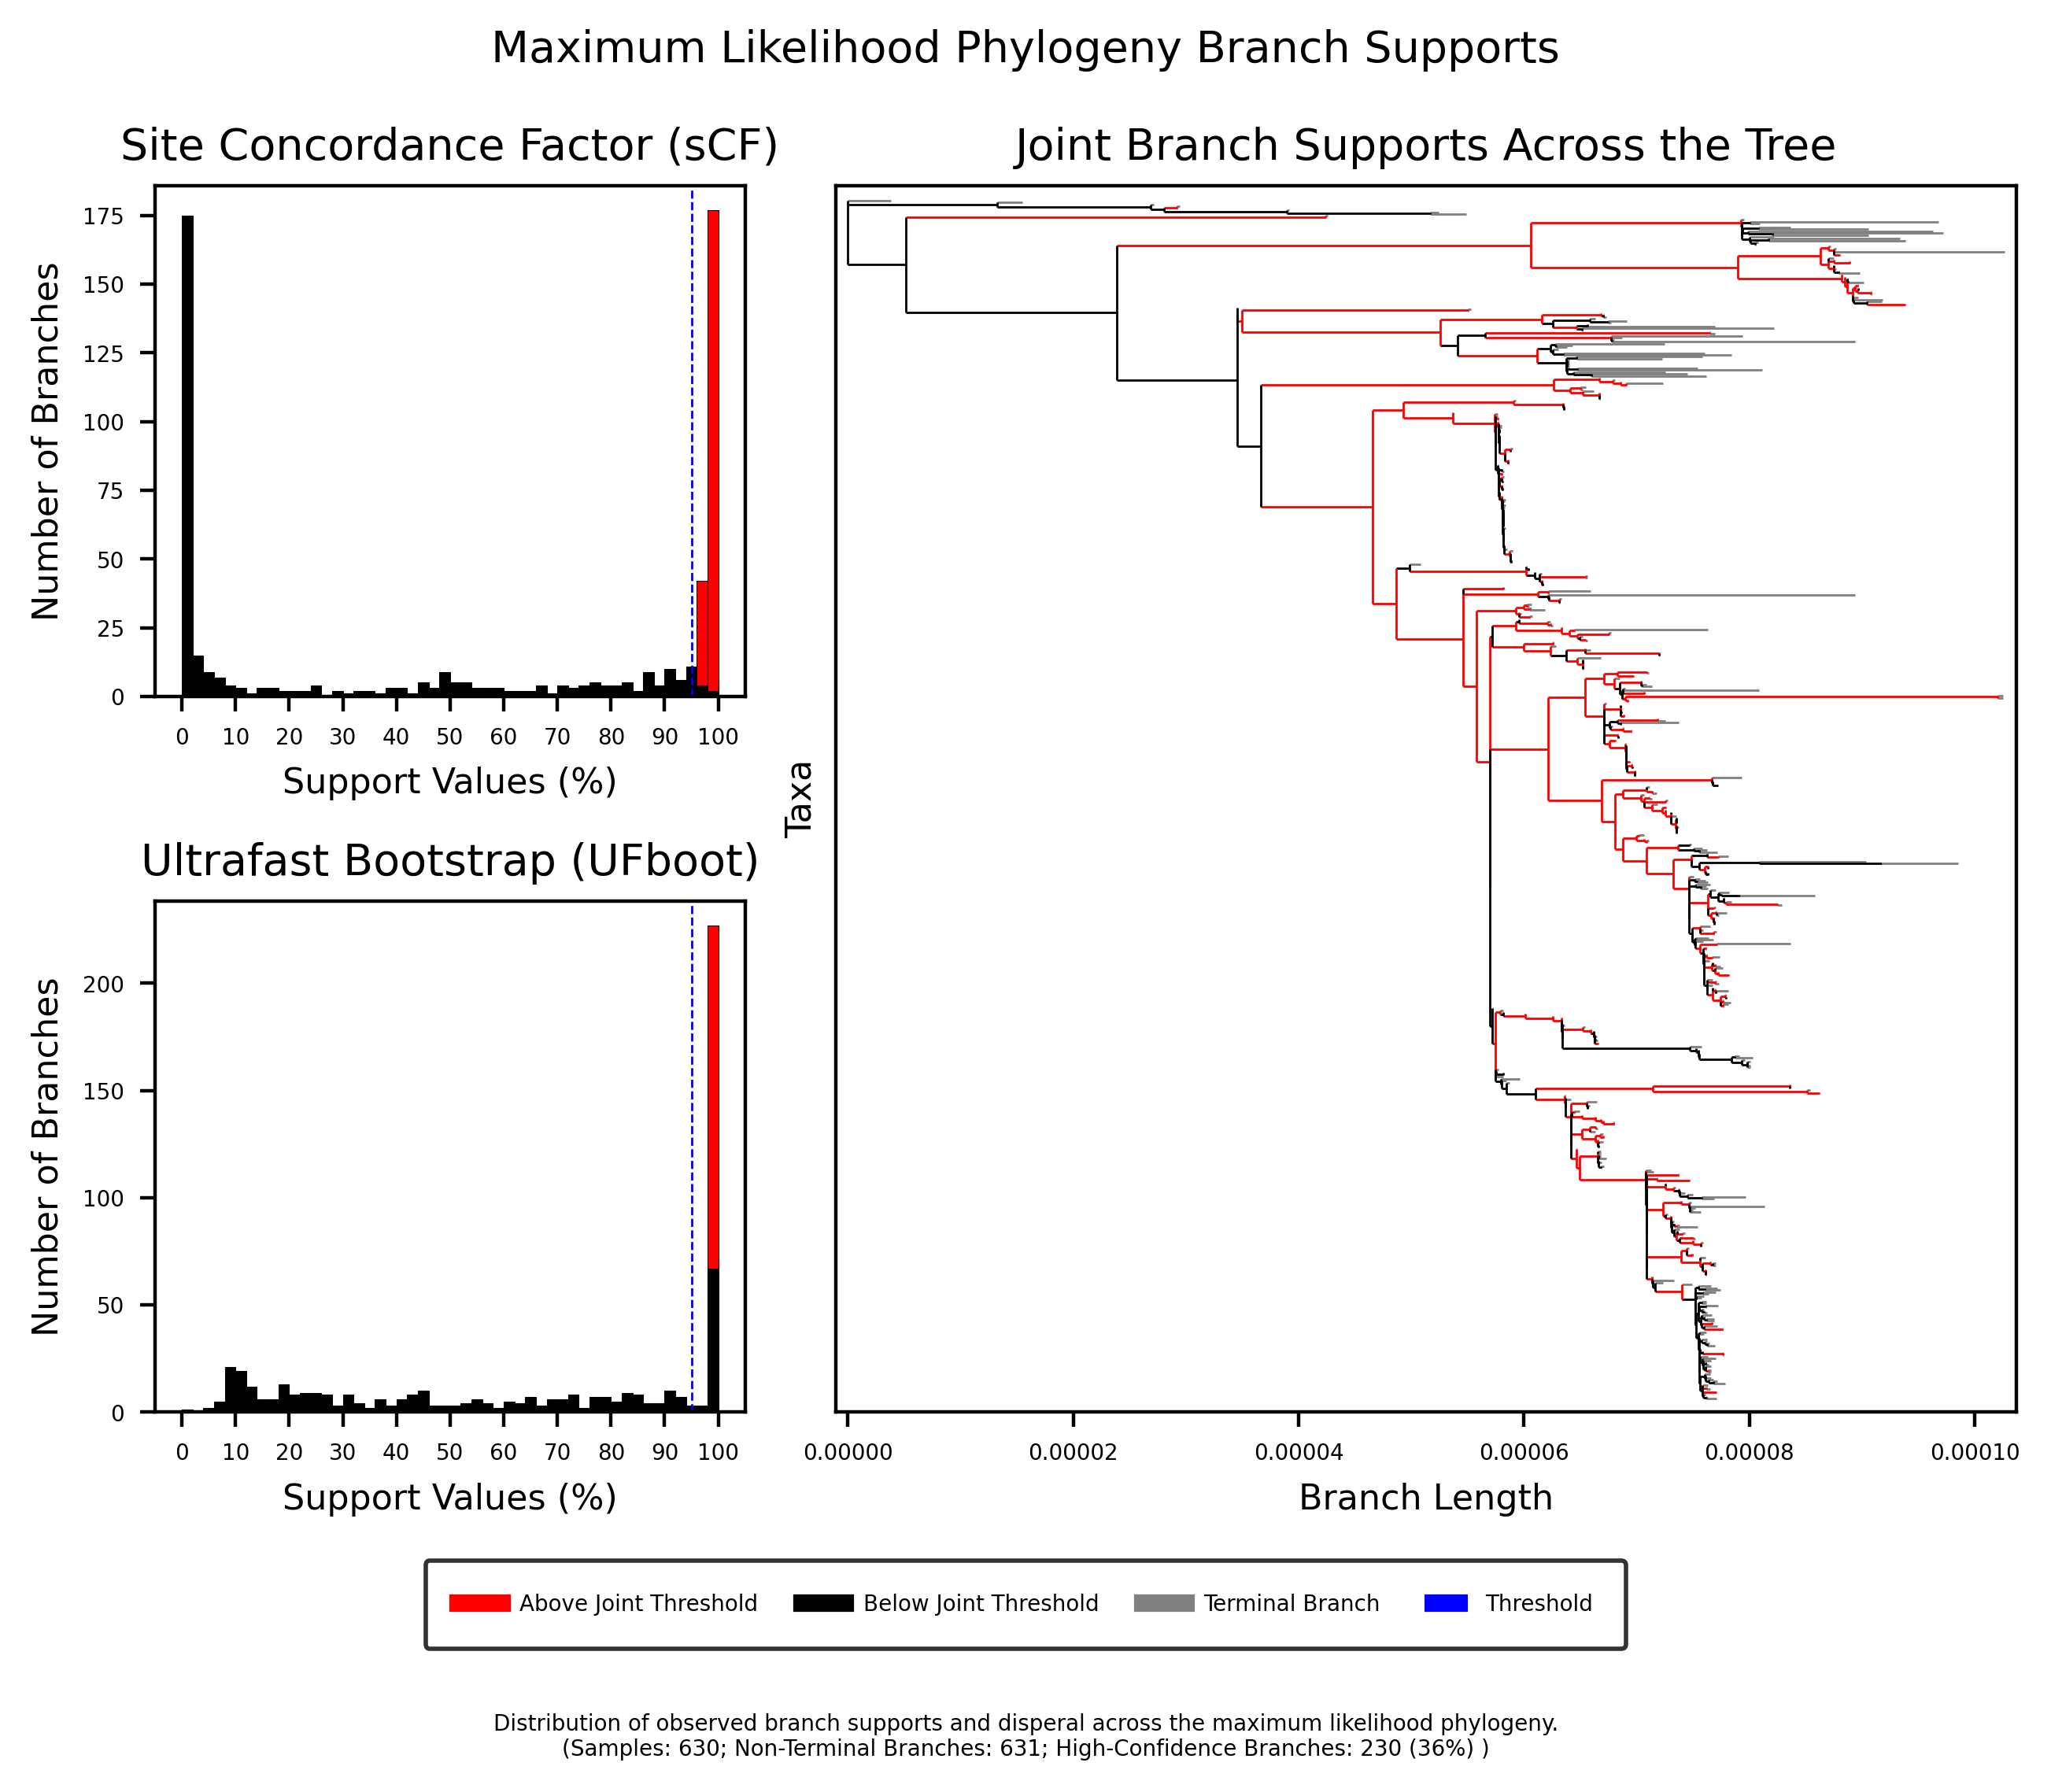

In [7]:
fig = plt.figure(constrained_layout=True, 
                 dpi=dpi,
                 figsize=figsize)

# Setup the grid
gs = gridspec.GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0:, 1:3])

# Local plot variables
hist_bins = [x for x in range(0,101,2)]
xticks_major = [x for x in range(0,101,10)]

# Filter out NA values
data = tree_df[(tree_df['sCF'] != NO_DATA_CHAR) & (tree_df['UFboot'] != NO_DATA_CHAR) ]

# -------------------------------
# sCF Axis
sns.histplot(data, 
             x="sCF", 
             ax=ax1,
             bins=hist_bins,
             hue="Branch_Support_Color",
             palette=[LOW_COL, HIGH_COL],
             legend=False,
             alpha=1)
ax1.axvline(x=SCF_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax1.set_xticks(xticks_major, minor=False)
ax1.set_xticklabels(xticks_major)
ax1.set_xlabel("Support Values (%)")
ax1.set_ylabel('Number of Branches')
ax1.set_title('Site Concordance Factor (sCF)')

# -------------------------------
# UFboot Axis
sns.histplot(data, 
             x="UFboot", 
             ax=ax2,
             bins=hist_bins,
             hue="Branch_Support_Color",
             palette=[LOW_COL, HIGH_COL],
             legend=False,
             alpha=1)
ax2.axvline(x=UFBOOT_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax2.set_xticks(xticks_major, minor=False)
ax2.set_xticklabels(xticks_major)
ax2.set_ylabel('Number of Branches')
ax2.set_xlabel("Support Values (%)")
ax2.set_title('Ultrafast Bootstrap (UFboot)')

# -------------------------------
# Phylogeny
Phylo.draw(tree,
           axes=ax3,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

# Test plot tips
#tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
#ax3.scatter(data=tip_data, x="coord_x", y="coord_y", s=0.5, c="grey")

ax3.set_xlabel('Branch Length')
ax3.set_ylabel('Taxa')
ax3.set_yticks([])
ax3.set_yticklabels([])

x_buffer = max(tree_df["coord_x"]) * 0.01
y_buffer = math.ceil(len(tree.get_terminals()) * 0.01)

ax3.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)
# Deepest nodes at top, means y top value is 0, and bottom is high
ax3.set_ylim(len(tree.get_terminals()) + y_buffer, 0 - y_buffer)
ax3.set_title("Joint Branch Supports Across the Tree")

# -------------------------------
# Figure title
fig.suptitle("Maximum Likelihood Phylogeny Branch Supports")

# -------------------------------
# Legend
legend_lines = [lines.Line2D([0], [0], color=HIGH_COL, lw=4),
                lines.Line2D([0], [0], color=LOW_COL, lw=4),
                lines.Line2D([0], [0], color=TERM_COL, lw=4),
                lines.Line2D([0], [0], color=THRESH_COL, lw=4, ls="--"),
               ]

legend_labels = ["Above Joint Threshold",
                 "Below Joint Threshold",
                 "Terminal Branch",
                 "Threshold"]

fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           frameon=True,
           borderpad=1.5,
           edgecolor="black")

# -------------------------------
# Caption
num_terminal_nodes = len(tree_df[tree_df["Branch_Support_Color"] == TERM_COL])
num_internal_nodes = len(tree_df[tree_df["Branch_Support_Color"] != TERM_COL])
num_high_support = len(tree_df[tree_df["Branch_Support_Color"] == HIGH_COL])
num_low_support = len(tree_df[tree_df["Branch_Support_Color"] == LOW_COL])
perc_high_support = (num_high_support / num_internal_nodes) * 100

caption_text = ("Distribution of observed branch supports and disperal across the maximum likelihood phylogeny." 
                + "\n(" 
                + "Samples: {}".format(num_terminal_nodes) 
                + "; "
                + "Non-Terminal Branches: {}".format(num_internal_nodes)
                + "; "
                + "High-Confidence Branches: {0} ({1:.0f}%)".format(num_high_support, perc_high_support)
                + " )"
               )
fig.text(0.5, -0.15, caption_text, ha='center')

# -------------------------------
# Save figure
out_path = os.path.join(outdir, SCRIPT_NAME + "." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Test

In [9]:
"""fig, ax1 = plt.subplots(1, dpi=dpi)

Phylo.draw(tree,
           axes=ax1,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
#ax3.scatter(data=tip_data, x="coord_x", y="coord_y", s=0.5, c="grey")
heatmap_x = 0.00012
ax1.scatter(data=tip_data, 
            x=[heatmap_x for tip in tip_data["coord_y"]], 
            y="coord_y",
            )"""

'fig, ax1 = plt.subplots(1, dpi=dpi)\n\nPhylo.draw(tree,\n           axes=ax1,\n           show_confidence=False, \n           label_func = lambda x:\'\', \n           do_show=False,\n          )\n\ntip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]\n#ax3.scatter(data=tip_data, x="coord_x", y="coord_y", s=0.5, c="grey")\nheatmap_x = 0.00012\nax1.scatter(data=tip_data, \n            x=[heatmap_x for tip in tip_data["coord_y"]], \n            y="coord_y",\n            )'